# Аналитика в Яндекс.Афише

### Цель анализа:
Оптимизация маркетинговых затрат

### Исходные данные:
  - лог сервера с данными о посещениях сайта Яндекс.Афиши,
  - выгрузка всех заказов за этот период,
  - статистика рекламных расходов

## Оглавление
* [Загрузка данных и подготовка к анализу](#first-bullet)
* [Продукт](#second-bullet)
* [Продажи](#third-bullet)
* [Маркетинг](#fourth-bullet)
* [Общий вывод](#fifth-bullet)

In [2597]:
# Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
import datetime
import warnings
warnings.filterwarnings('ignore')

In [2598]:
pd.options.display.float_format = '{:.2f}'.format #форматируем вывод данных float на экран

In [2599]:
plt.style.use('fivethirtyeight') # задаем стиль графиков

## Загрузка данных и подготовка к анализу <a class="anchor" id="first-bullet"></a>

Загружаем исходне датасеты и просматриваем первые 5 строк. Просматриваем общую информацию по датасетам методом `info`

In [2600]:
visits = pd.read_csv('/datasets/visits_log.csv')
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [2601]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [2602]:
orders = pd.read_csv('/datasets/orders_log.csv')
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [2603]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [2604]:
costs = pd.read_csv('/datasets/costs.csv')
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [2605]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Пропущенных значений в таблицах нет, требуется преобразование типов данных в столбцах с датами из `object`  в формат даты. Также в датасетах `visits` и `orders` необходимо переименовать названия столбцов - превести их к нижнему регистру и заменить пробелы на `_`.

In [2606]:
# Меняем названия столбцов
visits.columns = [col.lower().replace(' ','_') for col in visits.columns]
print('visits:', visits.columns)
orders.columns = [col.lower().replace(' ','_') for col in orders.columns]
print('orders:', orders.columns)

visits: Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')
orders: Index(['buy_ts', 'revenue', 'uid'], dtype='object')


In [2607]:
# Преобразум тип данных для столбцов с датой и временем
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format="%Y-%m-%d %H:%M:%S")
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format="%Y-%m-%d %H:%M:%S")
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format="%Y-%m-%d %H:%M:%S")
costs['dt'] = pd.to_datetime(costs['dt'], format="%Y-%m-%d")

In [2608]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [2609]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [2610]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


Проверим данные в таблицах на наличие дубликатов

In [2611]:
visits.duplicated().sum()

0

In [2612]:
orders.duplicated().sum()

0

In [2613]:
costs.duplicated().sum()

0

Повторяющихся записей в таблице нет.  
Посмотрим на данные методом `describe`, найдем минимальные и максимальные значения в столбцах с датами.

In [2614]:
visits.describe()

,source_id,uid
count,359400.00,359400.00
mean,3.75,9202556994354921472.00
std,1.92,5298432824659611648.00
min,1.00,11863502262781.00
25%,3.00,4613406732167550976.00
50%,4.00,9227412908740601856.00
75%,5.00,13728237011236173824.00
max,10.00,18446676030785673216.00


In [2615]:
print('start_ts MIN:', visits['start_ts'].min())
print('start_ts MAX:', visits['start_ts'].max())
print('end_ts MIN:', visits['end_ts'].min())
print('end_ts MAX:', visits['end_ts'].max())

start_ts MIN: 2017-06-01 00:01:00
start_ts MAX: 2018-05-31 23:59:00
end_ts MIN: 2017-06-01 00:02:00
end_ts MAX: 2018-06-01 01:26:00


In [2616]:
visits['device'].value_counts()

desktop    262567
touch       96833
Name: device, dtype: int64

In [2617]:
orders.describe()

,revenue,uid
count,50415.00,50415.00
mean,5.00,9098160634289729536.00
std,21.82,5285741550834715648.00
min,0.00,313578113262317.00
25%,1.22,4533566627250599936.00
50%,2.50,9102273602618561536.00
75%,4.89,13682901980465401856.00
max,2633.28,18446167067214817280.00


In [2618]:
print('buy_ts MIN:', orders['buy_ts'].min())
print('buy_ts MAX:', orders['buy_ts'].max())

buy_ts MIN: 2017-06-01 00:10:00
buy_ts MAX: 2018-06-01 00:02:00


In [2619]:
orders[orders['revenue'] == 0].count()

buy_ts     51
revenue    51
uid        51
dtype: int64

У 51 заказа сумма заказа равна 0. Удалим эти строки из таблицы.

In [2620]:
orders.loc[orders['revenue'] == 0, 'revenue'] = np.nan
orders = orders.dropna()

In [2621]:
costs.describe()

,source_id,costs
count,2542.00,2542.00
mean,4.86,129.48
std,3.18,156.30
min,1.00,0.54
25%,2.00,21.95
50%,4.00,77.30
75%,9.00,170.06
max,10.00,1788.28


In [2622]:
print('dt MIN:', costs['dt'].min())
print('dt MAX:', costs['dt'].max())

dt MIN: 2017-06-01 00:00:00
dt MAX: 2018-05-31 00:00:00


### Общий вывод
Загружены данные о посещениях сайте, заказах и расходах. Данные представлены за период июнь 2017 - май 2018 гг. В данных нет пропущенных значений. Были выполнены следующие преобразования:  
  - Названия столбцов содержащих заглавные буквы или пробелы были преобразованы.  
  - Типы данных также преобразованы в соответствие с содержимым столбца.  
  - В таблице `orders` удалена информация о заказах с нулевой суммой заказа (51 строка).  
  


## Продукт <a class="anchor" id="second-bullet"></a>

Добавим в таблице `visits` информацию о дне, неделе и месяце начала сессии, а также информацию о первом всходе пользоваталея на сайт.

In [2623]:
visits['visit_day'] = visits['start_ts'].values.astype('datetime64[D]')
visits['visit_week'] = pd.to_datetime(visits['visit_day'], unit='d') - pd.to_timedelta(visits['visit_day'].dt.dayofweek, unit='d')
visits['visit_month'] = visits['start_ts'].values.astype('datetime64[M]')
visits.head()

,device,end_ts,source_id,start_ts,uid,visit_day,visit_week,visit_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-18,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-19,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-14,2018-05-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-25,2017-12-01


In [2624]:
first_visit = visits.groupby('uid')['visit_day'].min()
first_visit.name = 'first_visit_day'
visits = visits.join(first_visit, on='uid')
visits['first_visit_month'] = visits['first_visit_day'].values.astype('datetime64[M]')
visits.head()

,device,end_ts,source_id,start_ts,uid,visit_day,visit_week,visit_month,first_visit_day,first_visit_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-18,2017-12-01,2017-12-20,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-19,2018-02-01,2018-02-19,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-26,2017-07-01,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-14,2018-05-01,2018-03-09,2018-03-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-25,2017-12-01,2017-12-27,2017-12-01


Посчитаем количество уникальных пользователей в день (DAU), неделю (WAU) и месяц (MAU).

In [2625]:
print('DAU', visits.groupby('visit_day').agg({'uid':'nunique'}).mean().round())

DAU uid   908.00
dtype: float64


In [2626]:
print('WAU ', visits.groupby('visit_week').agg({'uid':'nunique'}).mean().round())

WAU  uid   5716.00
dtype: float64


In [2627]:
print('MAU ', visits.groupby('visit_month').agg({'uid':'nunique'}).mean().round())

MAU  uid   23228.00
dtype: float64


Рассчитаем `sticky factor` для  DAU/WAU (`sf_d_w`) и DAU/MAU (`sf_d_m`)

In [2628]:
sf_d_w = visits.groupby('visit_day').agg({'uid':'nunique'}).mean().round() / visits.groupby(['visit_month','visit_week']).agg({'uid':'nunique'}).mean().round()
sf_d_w

uid   0.18
dtype: float64

In [2629]:
sf_d_m = visits.groupby('visit_day').agg({'uid':'nunique'}).mean().round() / visits.groupby('visit_month').agg({'uid':'nunique'}).mean().round()
sf_d_m

uid   0.04
dtype: float64

Получается, что каждый уникальный пользователь не так уж часто пользуется приложением, примерно 1 раз в анализируемом периоде (неделя, месяц).

Оценим динамику DAU, WAU, MAU  в анализируемом периоде

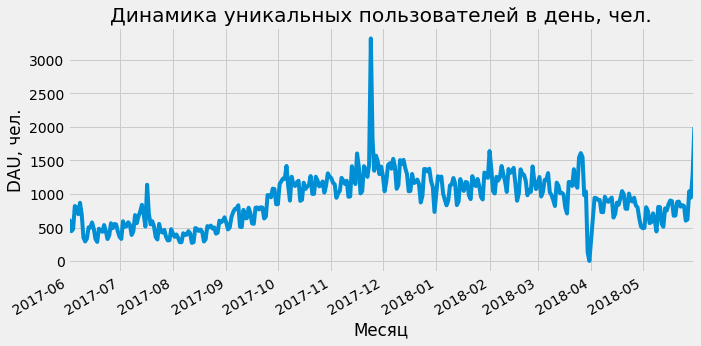

In [2630]:
visits.groupby('visit_day').agg({'uid':'nunique'}).plot(figsize=(10,5), legend=False, grid=True)
plt.title('Динамика уникальных пользователей в день, чел.')
plt.xlabel('Месяц')
plt.ylabel('DAU, чел.')
plt.show;

Исходя из графика можно отметить что в 2018 году наблюдается спад числа уникальных пользователей. Возможно это связано с фактором сезонности (больше всего концертов, спектаклей проходит в зимний период). Для выявления фактора сезонности 1 года недостаточно. Немного ниже проведем когортный анализ с целью выявления количества притоков новых пользователей в сервис.  
На графике явно заметны колебания пользователей внутри недели. Посторим график, чтобы это проверить.

In [2631]:
# добавляем столбцец с днем недели
visits['visit_day_of_week'] = visits['visit_day'].dt.dayofweek

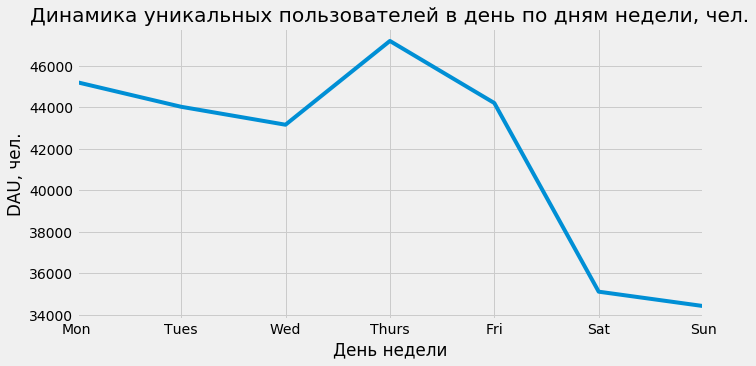

In [2632]:
visits.groupby('visit_day_of_week').agg({'uid':'nunique'}).plot(figsize=(10,5), legend=False, grid=True)
plt.title('Динамика уникальных пользователей в день по дням недели, чел.')
plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.xlabel('День недели')
plt.ylabel('DAU, чел.')
plt.show;

В целом сервисом наиболее активно интересуются в четверг. В выходные активность поситителей на минимальном уровне за неделю. Рекламные рассылки имеет смысл делать в четверг-пятницу, когда люди составляют планы на вечер пятницы и выходные дни.

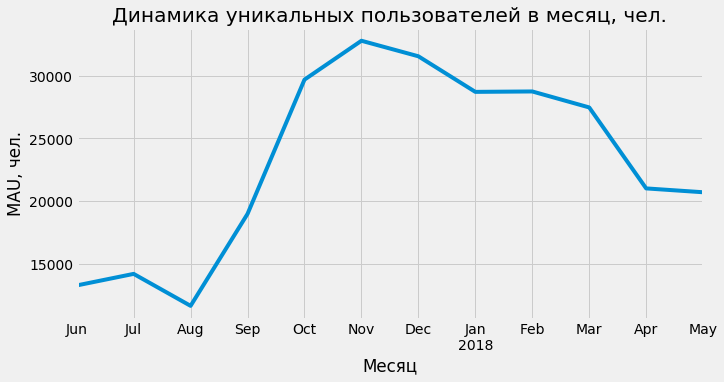

In [2633]:
visits.groupby('visit_month').agg({'uid':'nunique'}).plot(figsize=(10,5), legend=False)
plt.title('Динамика уникальных пользователей в месяц, чел.')
plt.xlabel('Месяц')
plt.ylabel('MAU, чел.')
plt.grid(which='minor', axis='both')
plt.show;

Посмотрим как меняется динамика числа пользователей в зависимости от устройства входа (ПК либо мобильный гаджет)

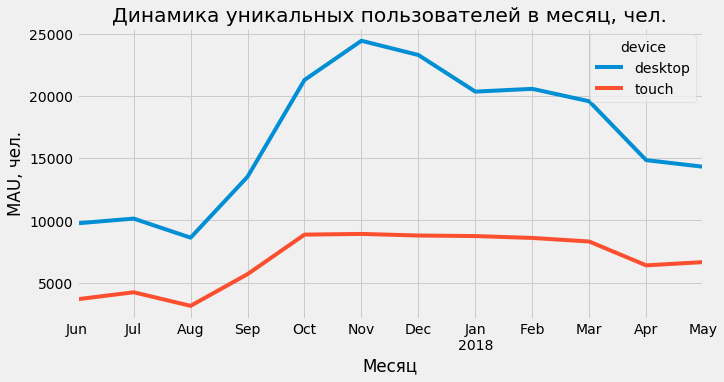

In [2634]:
visits.pivot_table(index='visit_month', columns='device', values='uid', aggfunc='nunique').plot(figsize=(10,5), legend=True)
plt.title('Динамика уникальных пользователей в месяц, чел.')
plt.xlabel('Месяц')
plt.ylabel('MAU, чел.')
plt.grid(which='minor', axis='both')
plt.show;

In [2635]:
visits['source_id'].value_counts()

4     101794
3      85610
5      66905
2      47626
1      34121
9      13277
10     10025
7         36
6          6
Name: source_id, dtype: int64

Рекламного источника с номером 8 вообще нет в исходных данных, в рекламных источниках 6 и 7 очень мало привлеченных пользователей, их в дальнейший анализ включать не будем.

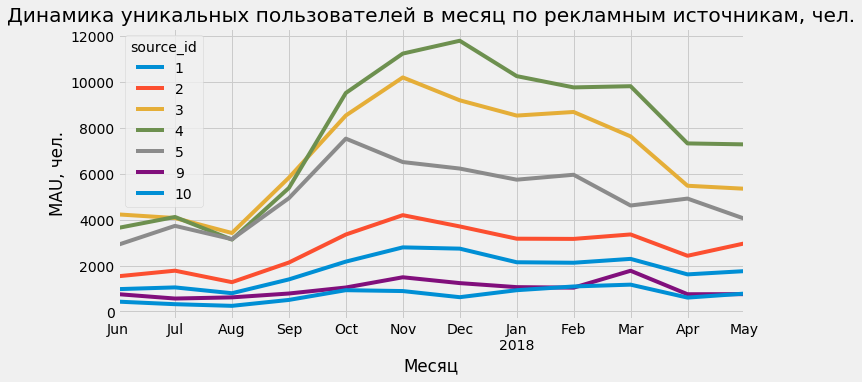

In [2636]:
visits[visits['source_id'].isin([1,2,3,4,5,9,10])] \
        .pivot_table(index='visit_month', columns='source_id', values='uid', aggfunc='nunique', fill_value=0) \
        .reset_index().set_index('visit_month') \
        .plot(figsize=(10,5), legend=True, grid=True)
plt.title('Динамика уникальных пользователей в месяц по рекламным источникам, чел.')
plt.xlabel('Месяц')
plt.ylabel('MAU, чел.')
plt.grid(which='minor', axis='both')
plt.show;

Таким образом основными рекламными каналами, генерирующими поток пользователей на сайт являются каналы 3,4,5. При этом генерируемый ими поток клиентов постоянно снижается начиная с конца 2017 года.

Посчитаем количество сессий в день.

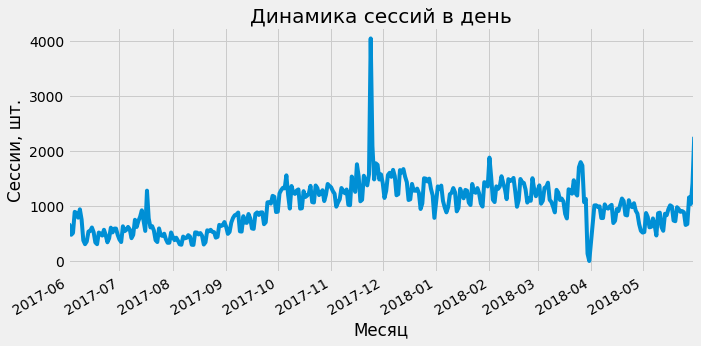

In [2637]:
visits.groupby('visit_day').agg({'uid':'count'}).plot(figsize=(10,5), legend=False, grid=True)
plt.title('Динамика сессий в день')
plt.xlabel('Месяц')
plt.ylabel('Сессии, шт.')
plt.show;

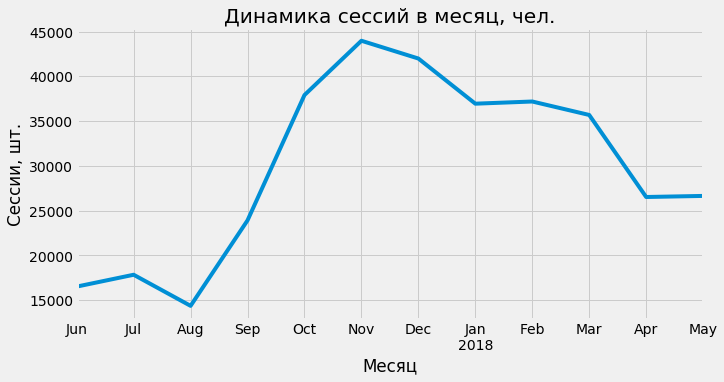

In [2638]:
visits.groupby('visit_month').agg({'uid':'count'}).plot(figsize=(10,5), legend=False)
plt.title('Динамика сессий в месяц, чел.')
plt.xlabel('Месяц')
plt.ylabel('Сессии, шт.')
plt.grid(which='minor', axis='both')
plt.show;

In [2639]:
visits_pivot = visits.pivot_table(index='visit_month', columns='device', values='uid', aggfunc='count').reset_index()

In [2640]:
visits_pivot['total'] = visits_pivot['desktop'] + visits_pivot['touch']
visits_pivot['market_share_desktop'] = visits_pivot['desktop'] / visits_pivot['total'] * 100
visits_pivot['market_share_touch'] = visits_pivot['touch'] / visits_pivot['total'] * 100
visits_pivot = visits_pivot[['visit_month','market_share_desktop','market_share_touch']]
visits_pivot

device,visit_month,market_share_desktop,market_share_touch
0,2017-06-01,74.87,25.13
1,2017-07-01,72.64,27.36
2,2017-08-01,75.61,24.39
3,2017-09-01,72.60,27.40
4,2017-10-01,72.27,27.73
5,2017-11-01,74.86,25.14
6,2017-12-01,74.11,25.89
7,2018-01-01,71.95,28.05
8,2018-02-01,72.82,27.18
9,2018-03-01,72.48,27.52


Посмотрим как менялась доля сессий по видам устройств

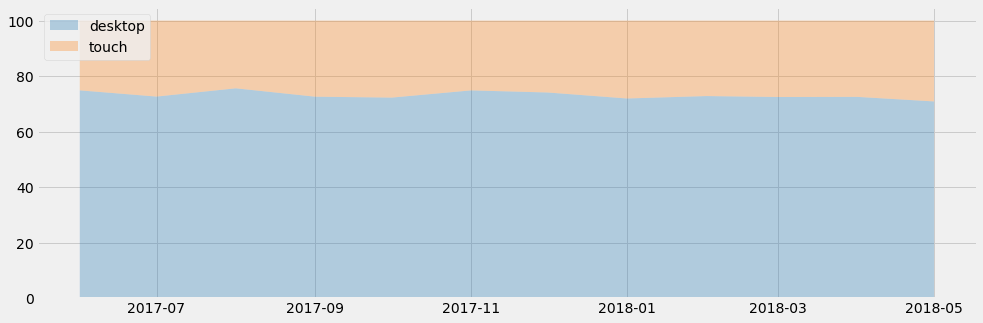

In [2641]:
x = visits_pivot['visit_month']
y1 = visits_pivot['market_share_desktop']
y2 = visits_pivot['market_share_touch']

fig, ax = plt.subplots(figsize=(15,5))
ax.stackplot(x, y1, y2, colors=('tab:blue','tab:orange'), labels=['desktop','touch'], alpha=0.3)
ax.legend(loc='upper left')
plt.show()


Можно отметить, что за год не произошло существенного увеличения доли мобильных устройств, большая часть посетителей по прежнему заходят на сайт с ПК (около 70% посетителей).

Посчитам среднее количество сессий на уникального пользователя в день и в месяц.

In [2642]:
session_per_uid = visits.groupby('visit_day')['uid'].agg(['nunique','count']).reset_index().set_index('visit_day')
session_per_uid['per_uid'] = session_per_uid['count'] / session_per_uid['nunique']
session_per_uid['visit_month'] = session_per_uid.index
session_per_uid['visit_month'] = session_per_uid['visit_month'].astype('datetime64[M]')

In [2643]:
session_per_uid.groupby('visit_month')['per_uid'].mean()

visit_month
2017-06-01   1.07
2017-07-01   1.08
2017-08-01   1.07
2017-09-01   1.08
2017-10-01   1.08
2017-11-01   1.09
2017-12-01   1.09
2018-01-01   1.09
2018-02-01   1.09
2018-03-01   1.09
2018-04-01   1.08
2018-05-01   1.09
Name: per_uid, dtype: float64

Среднее количество сессий в день на 1 уникального пользователя 1,08. Существенных изменений за год не произошло.

In [2644]:
session_per_uid = visits.groupby('visit_month')['uid'].agg(['nunique','count']).reset_index().set_index('visit_month')
session_per_uid['per_uid'] = session_per_uid['count'] / session_per_uid['nunique']
session_per_uid

,nunique,count,per_uid
visit_month,,,
2017-06-01,13259,16505,1.24
2017-07-01,14183,17828,1.26
2017-08-01,11631,14355,1.23
2017-09-01,18975,23907,1.26
2017-10-01,29692,37903,1.28
2017-11-01,32797,43969,1.34
2017-12-01,31557,41983,1.33
2018-01-01,28716,36939,1.29
2018-02-01,28749,37182,1.29


Подтвердилась информация описанная выше: пользователи достаточно редко повторно заходят в серви ЯндексюАфиса, в среднем количество сессий на 1 уникального пользователя в месяц 1.3

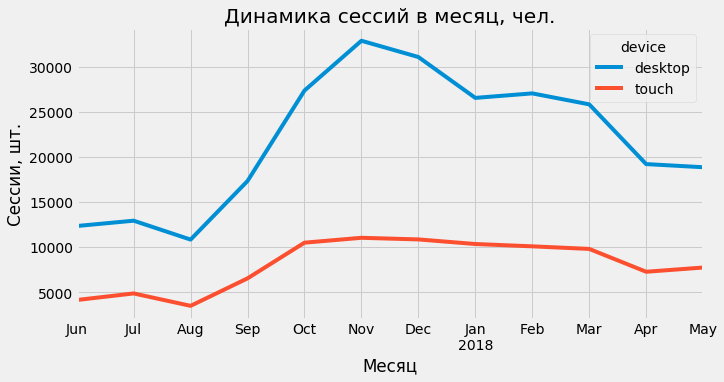

In [2645]:
visits.pivot_table(index='visit_month', columns='device', values='uid', aggfunc='count').plot(figsize=(10,5), legend=True)
plt.title('Динамика сессий в месяц, чел.')
plt.xlabel('Месяц')
plt.ylabel('Сессии, шт.')
plt.grid(which='minor', axis='both')
plt.show;

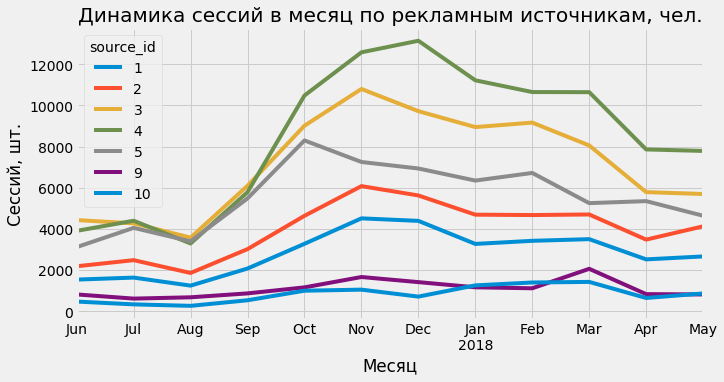

In [2646]:
visits[visits['source_id'].isin([1,2,3,4,5,9,10])] \
        .pivot_table(index='visit_month', columns='source_id', values='uid', aggfunc='count', fill_value=0) \
        .reset_index().set_index('visit_month') \
        .plot(figsize=(10,5), legend=True, grid=True)
plt.title('Динамика сессий в месяц по рекламным источникам, чел.')
plt.xlabel('Месяц')
plt.ylabel('Сессий, шт.')
plt.grid(which='minor', axis='both')
plt.show;

In [2647]:
visit_source = visits.pivot_table(index='visit_month', columns='source_id', values='uid', aggfunc='count', fill_value=0).reset_index()
visit_source

source_id,visit_month,1,2,3,4,5,6,7,9,10
0,2017-06-01,1544,2191,4435,3911,3122,0,2,823,477
1,2017-07-01,1641,2488,4276,4402,4056,1,2,621,341
2,2017-08-01,1251,1866,3582,3298,3403,1,1,684,269
3,2017-09-01,2082,3025,6102,5791,5489,1,3,874,540
4,2017-10-01,3282,4642,9017,10484,8303,0,5,1166,1004
5,2017-11-01,4518,6084,10802,12582,7256,1,1,1669,1056
6,2017-12-01,4396,5630,9724,13144,6940,1,9,1421,718
7,2018-01-01,3277,4697,8951,11223,6353,1,4,1170,1263
8,2018-02-01,3427,4679,9169,10653,6724,0,5,1122,1403
9,2018-03-01,3508,4707,8059,10647,5258,0,1,2067,1432


Посмотрим как менялась доля рекламных каналов в течении года

In [2648]:
visit_source.set_index('visit_month', inplace=True)

In [2649]:
visit_source['total'] = visit_source.iloc[:, 1: 10].sum(axis=1)
visit_source['ms_1'] = visit_source[1] / visit_source['total'] * 100
visit_source['ms_2'] = visit_source[2] / visit_source['total'] * 100
visit_source['ms_3'] = visit_source[3] / visit_source['total'] * 100
visit_source['ms_4'] = visit_source[4] / visit_source['total'] * 100
visit_source['ms_5'] = visit_source[5] / visit_source['total'] * 100
visit_source['ms_9'] = visit_source[9] / visit_source['total'] * 100
visit_source['ms_10'] = visit_source[10] / visit_source['total'] * 100
visit_source

source_id,1,2,3,4,5,6,7,9,10,total,ms_1,ms_2,ms_3,ms_4,ms_5,ms_9,ms_10
visit_month,,,,,,,,,,,,,,,,,
2017-06-01,1544,2191,4435,3911,3122,0,2,823,477,14961,10.32,14.64,29.64,26.14,20.87,5.50,3.19
2017-07-01,1641,2488,4276,4402,4056,1,2,621,341,16187,10.14,15.37,26.42,27.19,25.06,3.84,2.11
2017-08-01,1251,1866,3582,3298,3403,1,1,684,269,13104,9.55,14.24,27.34,25.17,25.97,5.22,2.05
2017-09-01,2082,3025,6102,5791,5489,1,3,874,540,21825,9.54,13.86,27.96,26.53,25.15,4.00,2.47
2017-10-01,3282,4642,9017,10484,8303,0,5,1166,1004,34621,9.48,13.41,26.04,30.28,23.98,3.37,2.90
2017-11-01,4518,6084,10802,12582,7256,1,1,1669,1056,39451,11.45,15.42,27.38,31.89,18.39,4.23,2.68
2017-12-01,4396,5630,9724,13144,6940,1,9,1421,718,37587,11.70,14.98,25.87,34.97,18.46,3.78,1.91
2018-01-01,3277,4697,8951,11223,6353,1,4,1170,1263,33662,9.74,13.95,26.59,33.34,18.87,3.48,3.75
2018-02-01,3427,4679,9169,10653,6724,0,5,1122,1403,33755,10.15,13.86,27.16,31.56,19.92,3.32,4.16


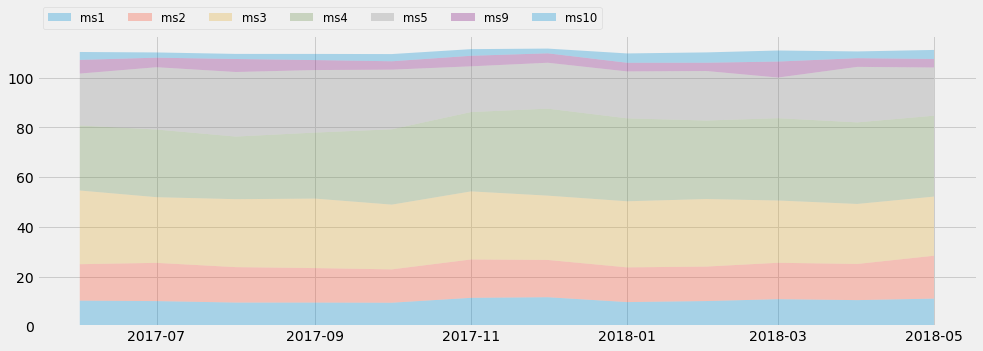

In [2650]:
x = visit_source.index
y1 = visit_source['ms_1']
y2 = visit_source['ms_2']
y3 = visit_source['ms_3']
y4 = visit_source['ms_4']
y5 = visit_source['ms_5']
y9 = visit_source['ms_9']
y10 = visit_source['ms_10']

fig, ax = plt.subplots(figsize=(15,5))
ax.stackplot(x, y1, y2, y3, y4, y5, y9, y10, labels=['ms1','ms2','ms3','ms4','ms5','ms9','ms10'], alpha=0.3)
ax.legend(ncol=7, bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.show()


Основное привлечение клиентов приходится на каналы 3,4,5, при этом доля канала 4 немного выросла за год, каналов 3 и 5 несущественно снизилась.

В целом анализ по количеству сессий повторяет динамику рассчитанную по количеству уникальных пользователей, в том числе по девайсам входа и каналам привлечения. 

Рассчитаем сколько в среднем длиться 1 сессия. Для этого посмотрим как выглядит распределение продолжительности сессии на гистограмме.

In [2651]:
visits['session_time'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

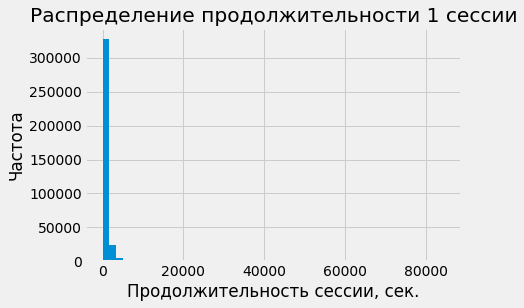

In [2652]:
visits['session_time'].hist(bins=50)
plt.title('Распределение продолжительности 1 сессии')
plt.xlabel('Продолжительность сессии, сек.')
plt.ylabel('Частота')
plt.show;

В исходных данных есть выбросы по продолжительности сессий, оставим для дальнейшего анализа сессии продолжительностью не более 1 час (3600 секунд)

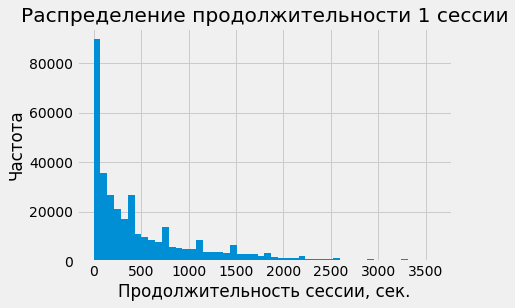

In [2653]:
visits['session_time'].hist(bins=50, range=(0,3600))
plt.title('Распределение продолжительности 1 сессии')
plt.xlabel('Продолжительность сессии, сек.')
plt.ylabel('Частота')
plt.show;

In [2654]:
session_time = visits.groupby('visit_month')['session_time'].agg({'median'}).reset_index().set_index('visit_month')
session_time

,median
visit_month,
2017-06-01,300
2017-07-01,300
2017-08-01,240
2017-09-01,300
2017-10-01,300
2017-11-01,300
2017-12-01,300
2018-01-01,300
2018-02-01,300


In [2655]:
session_time = visits.groupby('device')['session_time'].agg({'median'}).reset_index().set_index('device')
session_time

,median
device,
desktop,360
touch,180


В среднем пользовательская сессия составляет 5 минут, при этом есть отличие в продолжительности по девайсу входа, с ПК люди в среднем находятся на сайте 6 минут, с мобильных гаджетов 3 минуты. За год изменений в продолжительности 1 сессии нет.



Распределим пользователей по когортам в зависимости от месяца первого посещения сервиса.

In [2656]:
visits['visit_cohort_lf'] = ((visits['visit_month'] - visits['first_visit_month']) / np.timedelta64(1,'M')).round()

In [2657]:
cohorts = visits.pivot_table(index='first_visit_month', columns='visit_cohort_lf', values='uid', aggfunc='nunique')

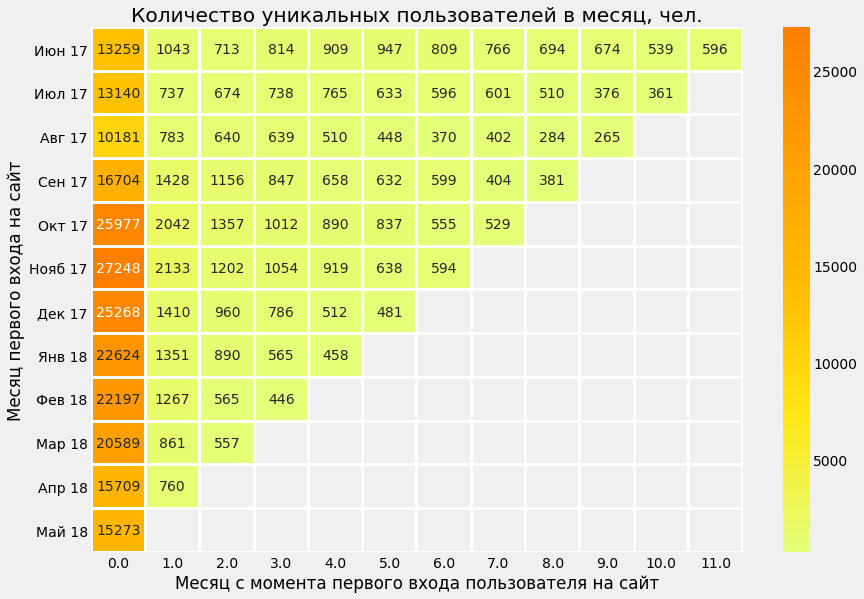

In [2658]:
plt.figure(figsize=(13, 9))
plt.title('Количество уникальных пользователей в месяц, чел.')
sns.heatmap(cohorts, annot=True, fmt='.0f', linewidths=2, linecolor='white',cmap="Wistia")
plt.gca().set_yticklabels(['Июн 17', 'Июл 17', 'Авг 17', 'Сен 17', 'Окт 17', 'Нояб 17', 'Дек 17','Янв 18' , 'Фев 18', 'Мар 18', 'Апр 18', 'Май 18'])
plt.xlabel('Месяц с момента первого входа пользователя на сайт')
plt.ylabel('Месяц первого входа на сайт')
plt.show;

Рассчитаем Retention Rate.

In [2659]:
cohorts = visits.groupby(['first_visit_month','visit_cohort_lf'])['uid'].nunique().reset_index().set_index('first_visit_month')

In [2660]:
initial_users_count = visits[visits['visit_cohort_lf'] == 0] \
        .groupby('first_visit_month')['uid'].nunique().reset_index().set_index('first_visit_month')

In [2661]:
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

In [2662]:
cohorts = cohorts.join(initial_users_count, on='first_visit_month')

In [2663]:
cohorts['retention_rate'] = cohorts['uid'] / cohorts['cohort_users'] * 100

In [2664]:
retention_pivot = cohorts.pivot_table(index='first_visit_month',columns='visit_cohort_lf',values='retention_rate',aggfunc='sum')
retention_pivot.fillna('')

visit_cohort_lf,0.00,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,11.00
first_visit_month,,,,,,,,,,,,
2017-06-01,100.00,7.87,5.38,6.14,6.86,7.14,6.10,5.78,5.23,5.08,4.07,4.50
2017-07-01,100.00,5.61,5.13,5.62,5.82,4.82,4.54,4.57,3.88,2.86,2.75,
2017-08-01,100.00,7.69,6.29,6.28,5.01,4.40,3.63,3.95,2.79,2.60,,
2017-09-01,100.00,8.55,6.92,5.07,3.94,3.78,3.59,2.42,2.28,,,
2017-10-01,100.00,7.86,5.22,3.90,3.43,3.22,2.14,2.04,,,,
2017-11-01,100.00,7.83,4.41,3.87,3.37,2.34,2.18,,,,,
2017-12-01,100.00,5.58,3.80,3.11,2.03,1.90,,,,,,
2018-01-01,100.00,5.97,3.93,2.50,2.02,,,,,,,
2018-02-01,100.00,5.71,2.55,2.01,,,,,,,,


In [2665]:
retention_pivot.mean(axis=0)

visit_cohort_lf
0.00    100.00
1.00      6.52
2.00      4.63
3.00      4.28
4.00      4.06
5.00      3.94
6.00      3.70
7.00      3.75
8.00      3.55
9.00      3.52
10.00     3.41
11.00     4.50
dtype: float64

Коэффициент удержания низкий, только 6,5% пользователей повторно возвращаются в сервис во второй месяц. При этом дальше коэффициент удержания практически не падает, примерно одно и тоже число пользователей возвращается в сервис каждый месяц.

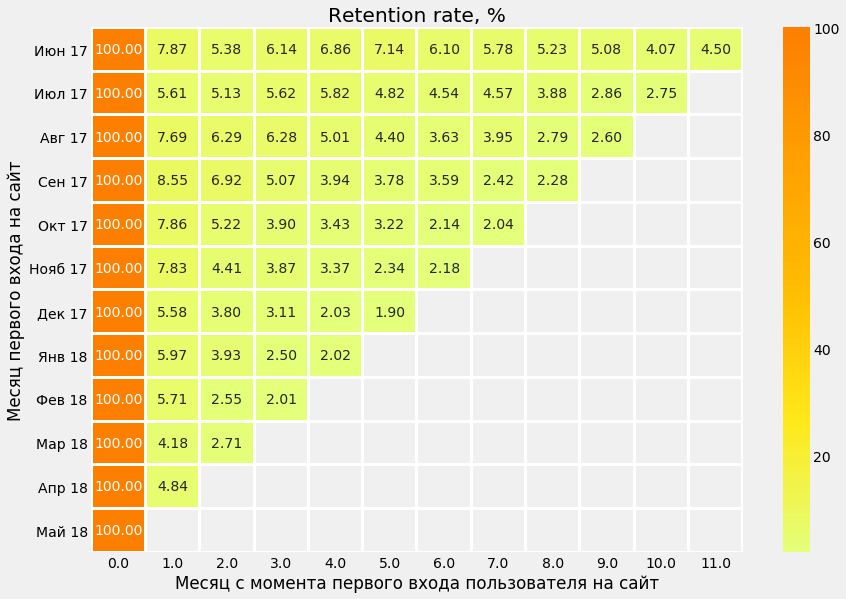

In [2666]:
plt.figure(figsize=(13, 9))
plt.title('Retention rate, %')
sns.heatmap(retention_pivot, annot=True, fmt='.2f', linewidths=2, linecolor='white',cmap="Wistia")
plt.gca().set_yticklabels(['Июн 17', 'Июл 17', 'Авг 17', 'Сен 17', 'Окт 17', 'Нояб 17', 'Дек 17','Янв 18' , 'Фев 18', 'Мар 18', 'Апр 18', 'Май 18'])
plt.xlabel('Месяц с момента первого входа пользователя на сайт')
plt.ylabel('Месяц первого входа на сайт')
plt.show;

Из графика видно, что коэффициент удержания по когортам падает с течением в времени, так для клиентов привлеченных в июне 2017 года коэффициент удержания составил 7,87%, а для привлеченных в мае 2018 года только 4,84%.



## Продажи <a class="anchor" id="third-bullet"></a>

In [2667]:
# Добавляем информацию о дне и месяце продажи
orders['buy_day'] = orders['buy_ts'].dt.date
orders['buy_month'] = orders['buy_day'].values.astype('datetime64[M]')

Добавим в таблицу `orders` информацию о первом входе пользователя на сайт и оставим только те записи о покупках которые были совершены по времени позже чем клиент зашел на сайт.

In [2668]:
visits = visits.sort_values(['uid','start_ts'])

In [2669]:
first_visit = visits.pivot_table(index='uid', values=['start_ts','device','source_id'], aggfunc='first').reset_index()

In [2670]:
first_visit.columns=(['uid','device', 'source_id', 'first_visit'])

In [2671]:
orders = orders.merge(first_visit, on='uid')
orders['test'] = orders['buy_ts'] >= orders['first_visit']

In [2672]:
orders['test'].value_counts()

True    50364
Name: test, dtype: int64

Все строки в таблице соответствуют условию: первая покупка совершена позже чем первый вход на сайт.

Посчитаем среднее время, которое проходит между первым входом на сайт и первой покупкой

In [2673]:
orders = orders.sort_values(['first_visit','buy_ts'])

In [2674]:
first_purchase = orders.pivot_table(index='uid', values=['buy_ts','first_visit','device','source_id','revenue','buy_month'], aggfunc='first').reset_index().set_index('uid')

In [2675]:
first_purchase['time_to_purchase'] = (first_purchase['buy_ts'] - first_purchase['first_visit']).dt.seconds

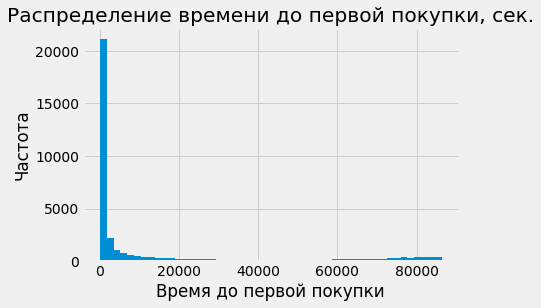

In [2676]:
first_purchase[['time_to_purchase']].hist(bins=50)
plt.title('Распределение времени до первой покупки, сек.')
plt.xlabel('Время до первой покупки')
plt.ylabel('Частота')
plt.show;

Как видно на графике распределения большинство покупок совершается в первые несколько минут после входа на сайт. При этом есть все первые поупки совершены в течении суток после первого входа на сайт. Расчитаем среднее время до совершения клиентом покупки.

In [2677]:
first_purchase['time_to_purchase'].median()

960.0

Таким образом среднестатистический клиент совершает первую покупку за 16 минут после первого входа на сайт.

Проверим если ли отличия между первым входом на сайт и покупкой по устройствам входа и каналам привлечения.

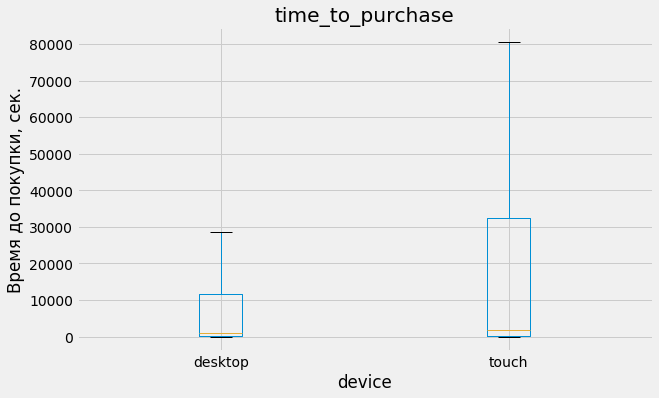

In [2678]:
first_purchase.boxplot('time_to_purchase', by='device',figsize=(10,6),showfliers=False);
plt.ylabel('Время до покупки, сек.')
plt.suptitle('');

In [2679]:
first_purchase.groupby('device')['time_to_purchase'].median()

device
desktop     840
touch      1860
Name: time_to_purchase, dtype: int64

Не смотря на то, что средняя пользовательская сессия на мобильных устройствах в два раза короче чем на ПК, пользователи мобильных устройств совершают первую покупку через 31 минуту, а пользователи настольных ПК через 14 минут.

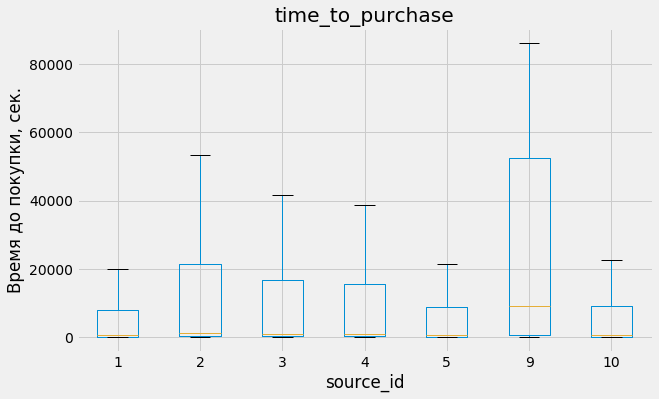

In [2680]:
first_purchase[first_purchase['source_id'].isin([1,2,3,4,5,9,10])].boxplot('time_to_purchase', by='source_id',figsize=(10,6),showfliers=False);
plt.ylabel('Время до покупки, сек.')
plt.suptitle('');

In [2681]:
first_purchase[first_purchase['source_id'].isin([1,2,3,4,5,9,10])].groupby('source_id')['time_to_purchase'].median()

source_id
1      540
2     1260
3     1080
4     1020
5      660
9     9090
10     720
Name: time_to_purchase, dtype: int64

В большинстве каналов привлечения пользователи совершают покупку в интервале 9-21 минуту, при этом в канале привлечения 9 среднее время покупки составляет 151 минуту.



Проверим сколько покупок совершает 1 клиент в течении месяца

In [2682]:
orders_to_month = orders[orders['buy_month'] < '2018-06-01'].groupby('buy_month')['uid'].agg(['nunique','count']).reset_index().set_index('buy_month')
orders_to_month['orders_per_uid'] = orders_to_month['count'] / orders_to_month['nunique']
orders_to_month

,nunique,count,orders_per_uid
buy_month,,,
2017-06-01,2022,2353,1.16
2017-07-01,1983,2362,1.19
2017-08-01,1471,1803,1.23
2017-09-01,2748,3383,1.23
2017-10-01,4673,5677,1.21
2017-11-01,4543,5644,1.24
2017-12-01,4937,6206,1.26
2018-01-01,3898,4721,1.21
2018-02-01,4258,5280,1.24


В среднем клиенты делают за период 1.2 покупки. Посмотрим какое максимальное количество покупок за год сделал один клиент.

In [2683]:
orders_to_uid = orders.groupby('uid')['buy_ts'].count().reset_index().set_index('uid').sort_values('buy_ts', ascending=False)

In [2684]:
orders_to_uid.head()

,buy_ts
uid,
3644482766749211722,239
13888745432979765063,238
11920452646463905188,227
6731421022966725351,183
3501596628378158474,150


In [2685]:
orders_to_uid.describe()

,buy_ts
count,36509.00
mean,1.38
std,3.45
min,1.00
25%,1.00
50%,1.00
75%,1.00
max,239.00


Есть клиенты, которые сделали несколько сотен заказов за год (у лидера 239 заказов за год), однако у большинства клиентов за год только один заказ. Если обобщить эту информацию с анализом проведенным выше, получается что клиент привлекается маркетологами, совершает одну покупку в течении суток и больше к услугам сервиса не обращается.

Рассчитаем средний чек

In [2686]:
avg_revenue = orders[orders['buy_month'] < '2018-06-01'].groupby('buy_month').agg({'revenue':'median'}).reset_index().set_index('buy_month')

In [2687]:
avg_revenue

,revenue
buy_month,
2017-06-01,2.44
2017-07-01,3.05
2017-08-01,2.78
2017-09-01,2.44
2017-10-01,2.44
2017-11-01,2.44
2017-12-01,2.69
2018-01-01,2.44
2018-02-01,2.69


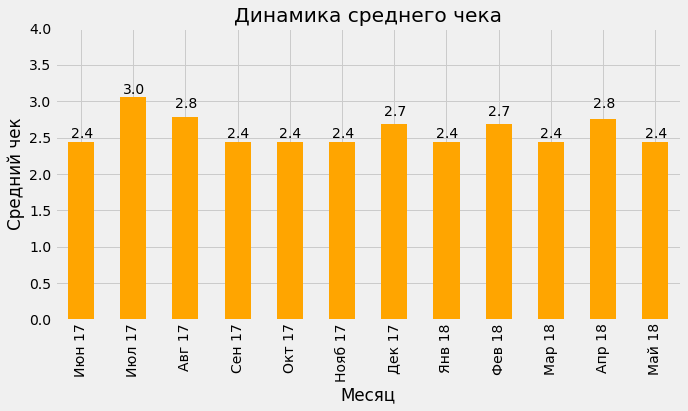

In [2688]:
avg_revenue['revenue'].plot(kind='bar', rot=90, figsize=(10,5), color='orange')
plt.title('Динамика среднего чека')
plt.xlabel('Месяц')
plt.gca().set_xticklabels(['Июн 17', 'Июл 17', 'Авг 17', 'Сен 17', 'Окт 17', 'Нояб 17', 'Дек 17','Янв 18' , 'Фев 18', 'Мар 18', 'Апр 18', 'Май 18'])
plt.ylabel('Средний чек')
c = -1.2
for i in avg_revenue['revenue'].round(1):
    c += 1
    j=i+0.1
    plt.text(c,j,i)
plt.ylim(0, 4)
plt.show;

За год средний чек существенно не изменился и составляет 2.44 у.е.

Посмотрим как выглядит средний чек по устройствам входа и каналам привлечения.

In [2689]:
first_purchase_dev = first_purchase[first_purchase['buy_month'] < '2018-06-01'] \
        .pivot_table(index='buy_month', columns='device', values='revenue', aggfunc='median')
first_purchase_dev

device,desktop,touch
buy_month,,
2017-06-01,2.44,2.38
2017-07-01,3.30,2.93
2017-08-01,2.93,2.44
2017-09-01,2.44,2.44
2017-10-01,2.44,2.44
2017-11-01,2.69,2.44
2017-12-01,2.75,2.44
2018-01-01,2.44,2.44
2018-02-01,2.57,2.44


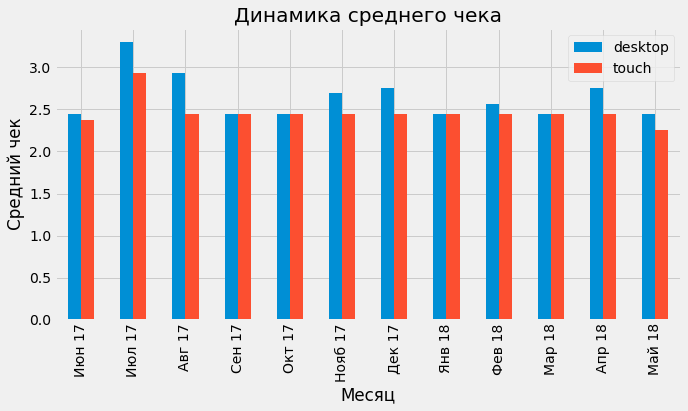

In [2690]:
first_purchase_dev.plot(kind='bar', figsize=(10,5))
plt.title('Динамика среднего чека')
plt.xlabel('Месяц')
plt.gca().set_xticklabels(['Июн 17', 'Июл 17', 'Авг 17', 'Сен 17', 'Окт 17', 'Нояб 17', 'Дек 17','Янв 18' , 'Фев 18', 'Мар 18', 'Апр 18', 'Май 18'])
plt.ylabel('Средний чек')
plt.legend(loc='best')
plt.show;

Существенного различия в средних чеках нет на мобильных девайсах и ПК.

In [2691]:
first_purchase_sour = first_purchase[(first_purchase['buy_month'] < '2018-06-01') & (first_purchase['source_id'].isin([1,2,3,4,5,9,10]))] \
        .pivot_table(index='buy_month', columns='source_id', values='revenue', aggfunc='median')
first_purchase_sour

source_id,1,2,3,4,5,9,10
buy_month,,,,,,,
2017-06-01,2.44,2.20,2.20,2.44,3.05,2.41,1.59
2017-07-01,3.67,4.40,3.05,3.30,3.05,2.44,1.65
2017-08-01,2.75,3.58,3.05,2.81,2.87,2.22,1.22
2017-09-01,2.75,2.44,2.08,2.44,2.57,2.44,1.44
2017-10-01,2.46,2.44,2.44,2.44,2.81,2.76,1.22
2017-11-01,2.69,2.93,2.44,2.75,2.75,2.14,2.20
2017-12-01,2.44,2.75,2.50,2.73,2.93,2.44,2.14
2018-01-01,2.44,2.47,2.75,2.44,2.44,1.83,2.14
2018-02-01,2.44,3.02,2.44,2.69,2.92,2.38,1.83


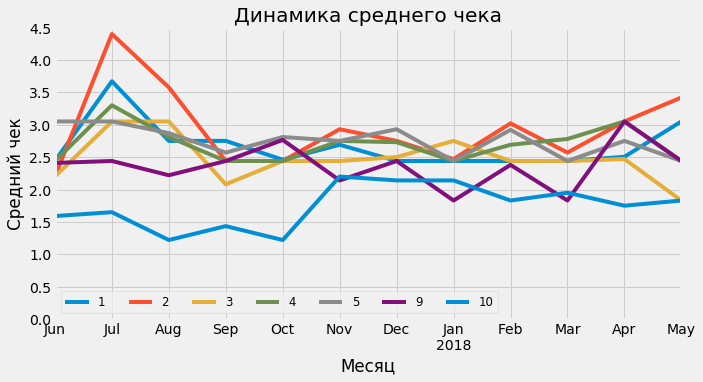

In [2692]:
first_purchase_sour.plot(figsize=(10,5))
plt.title('Динамика среднего чека')
plt.xlabel('Месяц')
plt.ylabel('Средний чек')
plt.legend(ncol=7, bbox_to_anchor=(0, 0), loc='lower left', fontsize='small')
plt.ylim(0, 4.5)
plt.grid(which='minor', axis='both')
plt.show;

In [2693]:
first_purchase_sour.mean()

source_id
1    2.67
2    2.94
3    2.47
4    2.69
5    2.75
9    2.37
10   1.75
dtype: float64

Наибольший средний чек в канале 2 (2.94 у.е.), наименьший в канале 10 (1.75 у.е.)



Рассчитаем LTV клиентов

In [2694]:
first_orders = orders.groupby('uid').agg({'buy_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

In [2695]:
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

In [2696]:
orders_new = pd.merge(orders,first_orders, on='uid')

In [2697]:
cohorts = orders_new.groupby(['first_order_month','buy_month']).agg({'revenue': 'sum'}).reset_index()

In [2698]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

In [2699]:
report['age'] = (report['buy_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

In [2700]:
report['ltv'] = report['revenue'] / report['n_buyers']
    
output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean')
    
output.cumsum(axis=1).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.73,5.21,5.65,6.61,7.63,8.36,9.31,9.90,10.45,11.06,11.63,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.51,7.66,7.79,7.93,8.09,8.24,8.39,
2017-08-01,5.28,5.75,6.21,6.60,7.10,7.38,7.59,8.00,8.29,8.48,,
2017-09-01,5.65,6.77,7.29,11.27,11.67,12.31,13.02,13.26,13.44,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.16,5.56,5.76,6.08,6.23,6.28,6.40,,,,,
2017-12-01,4.74,5.00,5.93,6.99,7.31,7.65,,,,,,
2018-01-01,4.14,4.43,4.73,4.88,4.94,,,,,,,
2018-02-01,4.16,4.44,4.51,4.59,,,,,,,,


In [2701]:
output.cumsum(axis=1).mean()

age
0     4.80
1     5.40
2     5.82
3     6.69
4     7.30
5     7.97
6     8.39
7     9.09
8    10.07
9     9.26
10   10.01
11   11.88
dtype: float64

Таким образом в среднем за полгода 1 клиент приносит сервису выручку в размере 7.97 у.е.

## Маркетинг <a class="anchor" id="fourth-bullet"></a>

In [2702]:
costs['month'] = costs['dt'].values.astype('datetime64[M]')

In [2703]:
total_costs = costs.pivot_table(index='month', columns='source_id', values='costs', aggfunc='sum').reset_index().set_index('month')

In [2704]:
total_costs['total'] = total_costs.iloc[:, 1: 10].sum(axis=1)

In [2705]:
total_costs.sum()

source_id
1        20833.27
2        42806.04
3       141321.63
4        61073.60
5        51757.10
9         5517.49
10        5822.49
total   308298.35
dtype: float64

Всего за год потратили 308.3 тыс. у.е. Наибольшие расходы приходятся на три канала генерирующие максимальный поток клиентов - 3, 4, 5.

<Figure size 432x288 with 0 Axes>

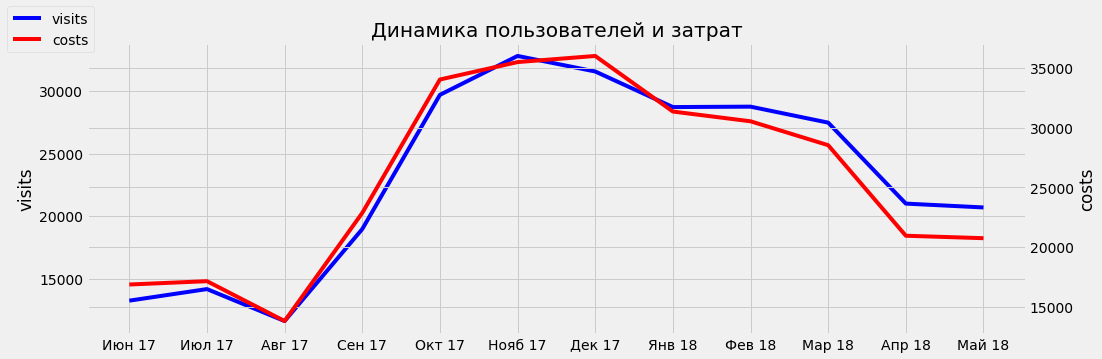

In [2706]:
x = ['Июн 17', 'Июл 17', 'Авг 17', 'Сен 17', 'Окт 17', 'Нояб 17', 'Дек 17','Янв 18' , 'Фев 18', 'Мар 18', 'Апр 18', 'Май 18'] 
y = visits.groupby('visit_month').agg({'uid':'nunique'}) 
z = total_costs['total'] 

fig = plt.figure()
fig, ax0 = plt.subplots(figsize=(15,5))
ax01 = ax0.twinx()
ax0.plot(x, y, color='blue', label='visits') 
ax01.plot(x, z, color='red', label='costs')
plt.title('Динамика пользователей и затрат')
ax0.set_ylabel('visits')
ax01.set_ylabel('costs')
fig.legend(loc='upper left')
plt.show;

График динамики расходов на привлечение клиентов во многом похож на помесячный график уникальных пользователей на сайте. Также с 2018 года наблюдается постепенное сокращение расходов.

Посчитаем сколько стоило привлечение одного уникального пользователя.

In [2707]:
first_purchase = first_purchase.reset_index()
first_purchase['first_visit_month'] = first_purchase['first_visit'].values.astype('datetime64[M]')

In [2708]:
orders_effect = first_purchase.groupby(['first_visit_month','source_id']).agg({'uid':'nunique'}) \
        .reset_index()

In [2709]:
costs_effect = costs.groupby(['month','source_id'])['costs'].sum().reset_index()

In [2710]:
effect = costs_effect.merge(orders_effect, left_on=['month','source_id'], right_on=['first_visit_month','source_id'])
effect['cost_per_user'] = effect['costs'] / effect['uid']
effect_pivot = effect.pivot_table(index='month', columns='source_id', values='cost_per_user')
effect_pivot.mean()

source_id
1     7.24
2    12.69
3    13.77
4     6.18
5     7.68
9     7.65
10    4.74
dtype: float64

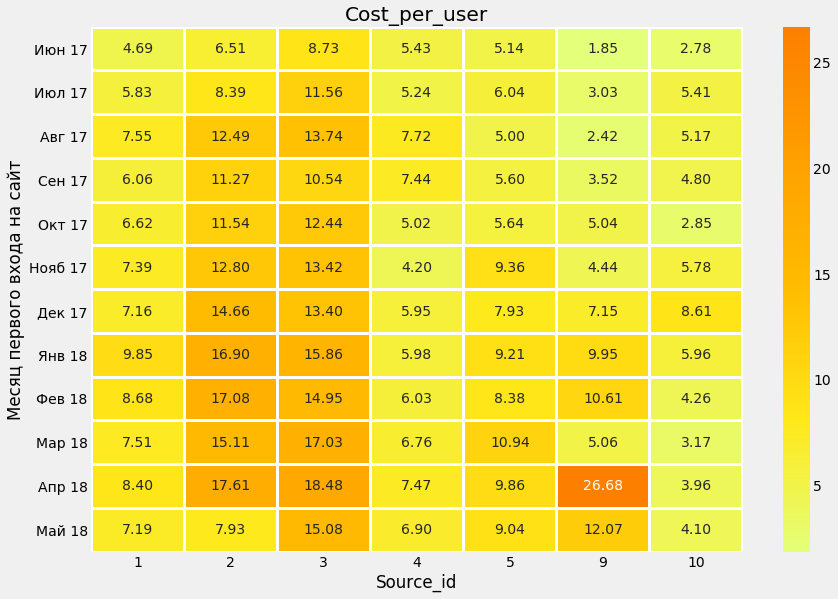

In [2711]:
plt.figure(figsize=(13, 9))
plt.title('Cost_per_user')
sns.heatmap(effect_pivot, annot=True, fmt='.2f', linewidths=2, linecolor='white',cmap="Wistia")
plt.gca().set_yticklabels(['Июн 17', 'Июл 17', 'Авг 17', 'Сен 17', 'Окт 17', 'Нояб 17', 'Дек 17','Янв 18' , 'Фев 18', 'Мар 18', 'Апр 18', 'Май 18'])
plt.xlabel('Source_id')
plt.ylabel('Месяц первого входа на сайт')
plt.show;

Наиболее дорогое привлечение пользователей в канале 3, в среднем за год 13.77 у.е. на клиента, наименьшие расходы в канале 10 (4.74 у.е.)

Рассчитаем CAC и ROMI

In [2712]:
monthly_costs = costs.groupby('month').sum()

In [2713]:
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new.groupby('first_order_month')['cac'].mean()

first_order_month
2017-06-01    8.91
2017-07-01    9.49
2017-08-01   10.80
2017-09-01    9.45
2017-10-01    8.37
2017-11-01    9.30
2017-12-01    8.75
2018-01-01    9.94
2018-02-01    8.96
2018-03-01    8.61
2018-04-01    9.80
2018-05-01    7.44
Name: cac, dtype: float64

In [2714]:
report_new['romi'] = report_new['ltv'] / report_new['cac']
output = report_new.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')

output.cumsum(axis=1).round(2).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.70,0.74,0.77,0.78,,
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.30,1.38,1.40,1.42,,,
2017-10-01,0.60,0.66,0.68,0.70,0.72,0.74,0.75,0.76,,,,
2017-11-01,0.56,0.60,0.62,0.65,0.67,0.68,0.69,,,,,
2017-12-01,0.54,0.57,0.68,0.80,0.84,0.87,,,,,,
2018-01-01,0.42,0.45,0.48,0.49,0.50,,,,,,,
2018-02-01,0.46,0.49,0.50,0.51,,,,,,,,


In [2715]:
output.cumsum(axis=1).mean(axis=0)

age
0    0.54
1    0.58
2    0.63
3    0.72
4    0.78
5    0.86
6    0.90
7    0.97
8    1.05
9    0.96
10   1.09
11   1.33
dtype: float64

Маркетинговые расходы на привлечение новых клиентов покрываются спустя только 11 месяцев (отношение LTV к CAC 1.09).



## Общий вывод <a class="anchor" id="fifth-bullet"></a>

  - В целом маркетологи генерируют достаточно большой поток новых пользователей каждый месяц (более 23 тыч.уникальных пользователей в месяц)
  - Большая часть пользователей посещает сервис с использованием ПК (70% всех посещений)
  - Основными рекламными каналами генерирующими поток клиентов являются каналы 3, 4, 5.
  - Основная зона повышения эффективности сервиса заключается в повышении коэффициента удержания клиентов (большинство новых уникальных клиентов воспользовавшись один раз сервисом больше на сайт не возвращаются, retention rate во второй месяц всего 6.5%, т.е. 93.5% привлеченных клиентов больше не возвращается на сайт).
  - Пользователи совершают покупку на сайте достаточно быстро, в среднем за 16 минут, средний чек покупки составляет 2.44 у.е.
  - В среднем через полгода 1 покупатель генерирует сервису 7.97 у.е. доходов.
  - Наибольшая сумма рекламных бюджетов (46%) потрачена на рекламный канал 3. При этом наибольший поток клиентов генерирует канал 4, средняя сумма привлечения 1 клиента в этом канале на 55% ниже чем в канале 3.  

#### Общие рекомендации:
  - снизить расходы на неэффективные каналы привлечения, прежде всего каналы 2, 3 (расходы на привлечение клиентов в данных каналах не покрываются LTV клиента даже за год). Переориентировать затраты на каналы с минимальными затратами на привлечение одного покупателя: 4 и 10.
  - разработать мероприятия по удержанию клиентов (например запустить программу лояльности для постоянных пользователей сервиса)